# CEA Simulations

In [110]:
#Uncomment the line below to install pywavan (needed for the wavelet segmentation)
#!pip install git+https://github.com/jfrob27/pywavan.git

Dependencies

In [1]:
from pywavan import fbm2d, powspec, imsmooth, fan_trans, apodize, padding, gauss_beam, nb_scale, congrid
from turbustat.statistics import PDF
import aplpy
from astropy.io import fits
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'family': 'serif', 'size': 32})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

## No driving

In [3]:
#Read map
HDU = fits.open('/Users/robitaij/postdoc/CEA_simu/density_output_00218_z.fits')
im = HDU[0].data

### Rebin the map
The map is binned to reduce the amount of calculation. The binning will not affect the inertial range.

In [5]:
imbin = congrid(im,np.array([1024,1024]))

INFO: Auto-setting vmin to  5.397e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.388e+00 [aplpy.core]


INFO: Auto-setting vmin to  5.525e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.339e+00 [aplpy.core]


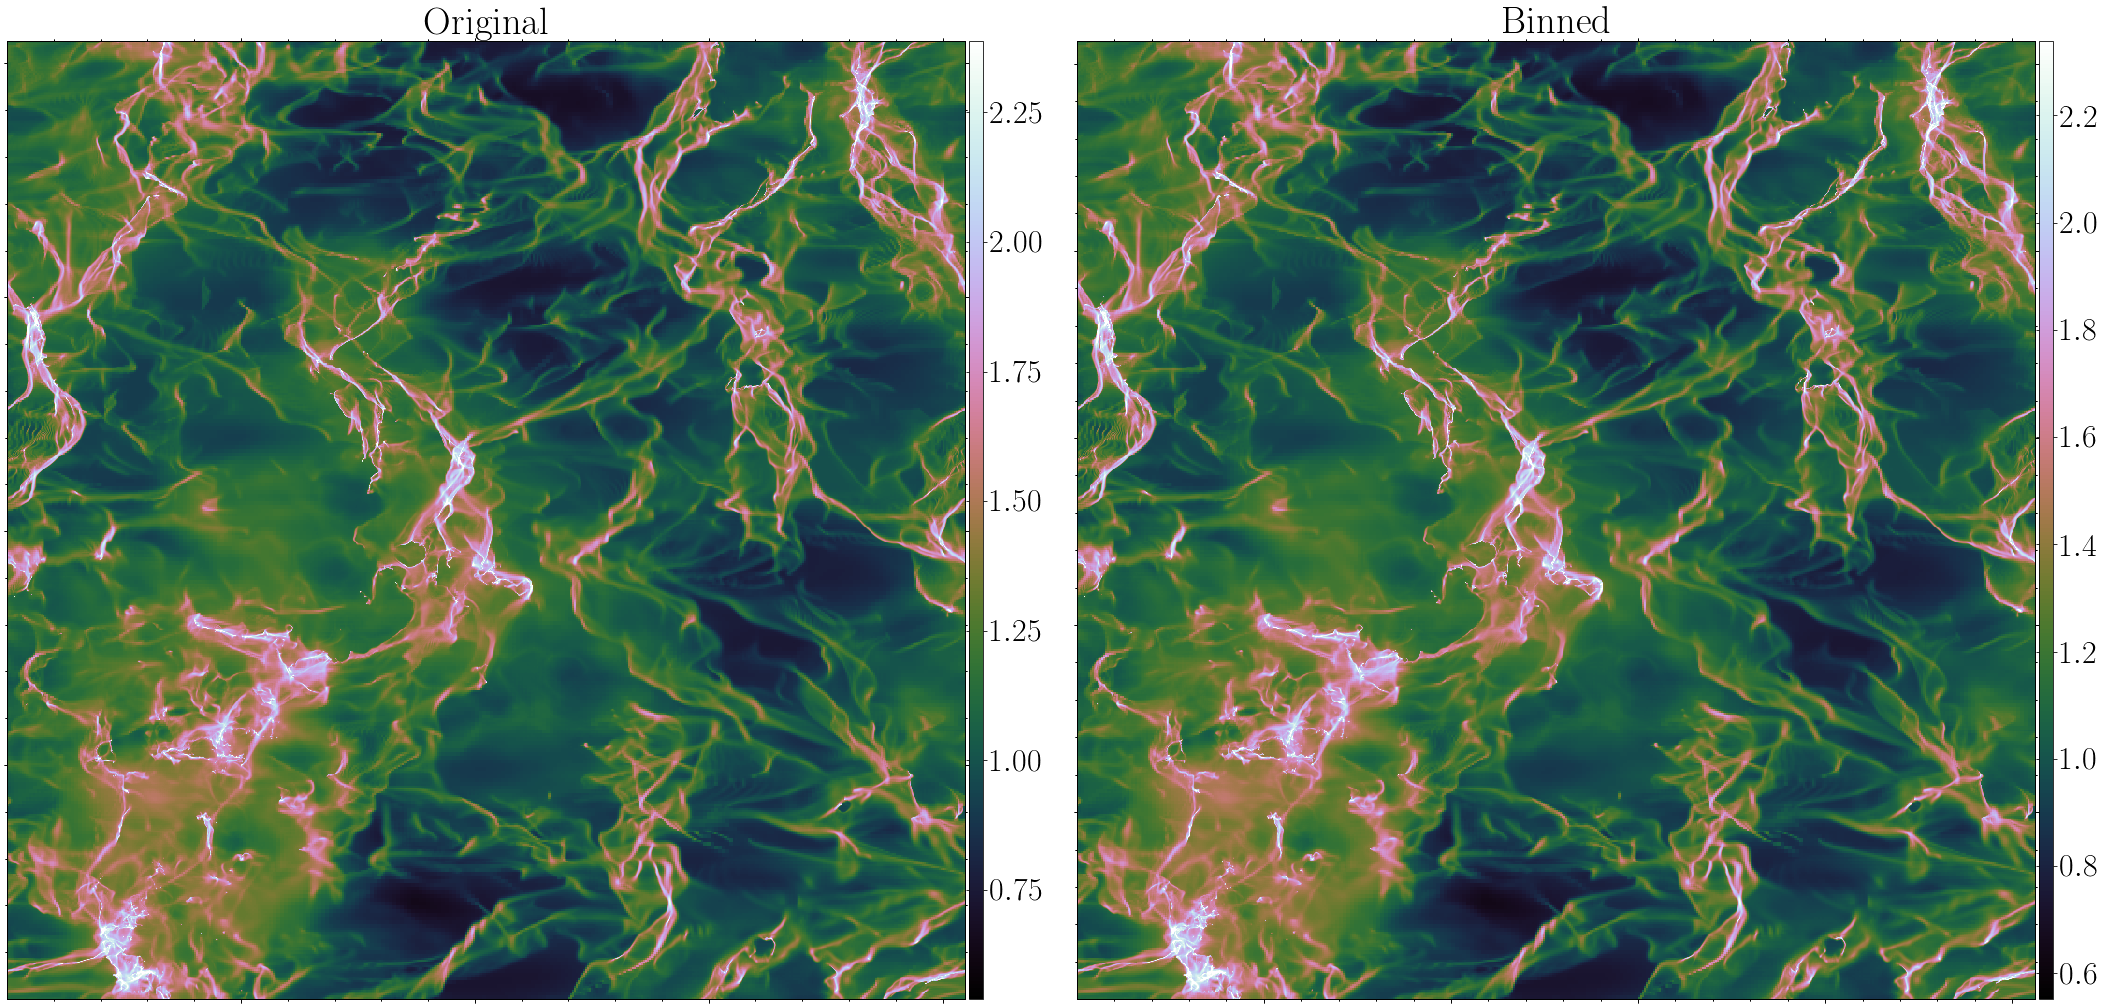

In [6]:
fig_all = plt.figure(1, figsize=(30,15))

fig = aplpy.FITSFigure(fits.PrimaryHDU(im), figure=fig_all, subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Original')

fig = aplpy.FITSFigure(fits.PrimaryHDU(imbin), figure=fig_all, subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Binned')

plt.tight_layout()

## Fourier Power spectrum analysis

In [8]:
################
#Binned map
################
meanimbin = np.mean(imbin)
imzmbin = imbin - meanimbin

#Fourier power spectrum
tab_kbin, spec_kbin = powspec(imzmbin, reso=1)

################
#Original map
################
meanim = np.mean(im)
imzm = im - meanim
del im

#Fourier power spectrum
tab_k, spec_k = powspec(imzm, reso=1)

Power law
-2.152035360935127


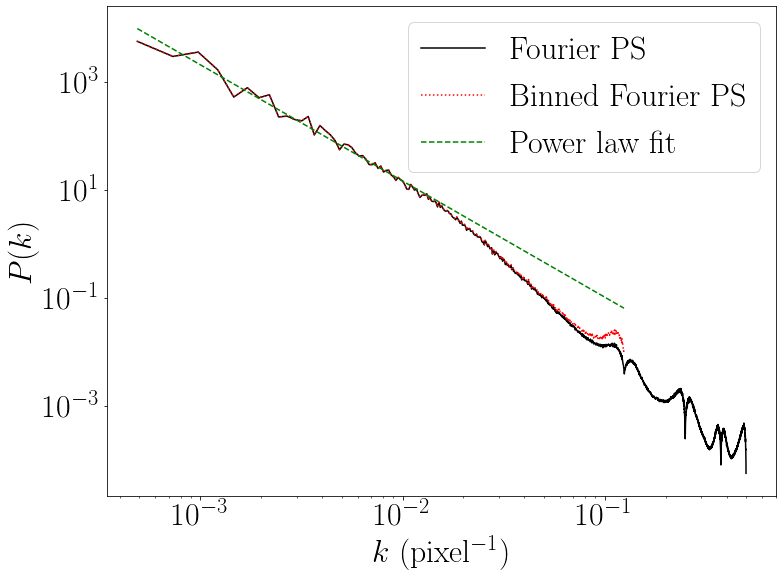

In [9]:
#Power law fit
limit = np.where((tab_kbin > tab_kbin[0]) & (tab_kbin < 0.05))
coef,cov = np.polyfit(np.log(tab_kbin[limit]),np.log(spec_kbin[limit]),deg=1,cov=True)
yfit = np.exp(coef[1])*tab_kbin**coef[0]

print('Power law')
print(coef[0])

plt.figure(figsize=(12,9))
plt.plot(tab_k[1:], spec_k[1:], color='black',label='Fourier PS', linewidth=1.5)
#Scales are divided by 4 because of the new pixel size & power multiplied by 4^2 because
#of the power normalisation by the number of pixels
plt.plot(tab_kbin[1:]/4., spec_kbin[1:]*4.**2.,':', color='red',label='Binned Fourier PS', linewidth=1.5)
plt.plot(tab_kbin[1:]/4., yfit[1:]*4.**2.,'--', color='green',label='Power law fit', linewidth=1.5)
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (pixel$^{-1}$)")
plt.ylabel(r"$P(k)$")
plt.legend()

The binned map has the same inertial range than the original map. First part of the spectrum can be fitted by a single power law of $-2.15$.

Text(0.5, 1.0, 'PDF')

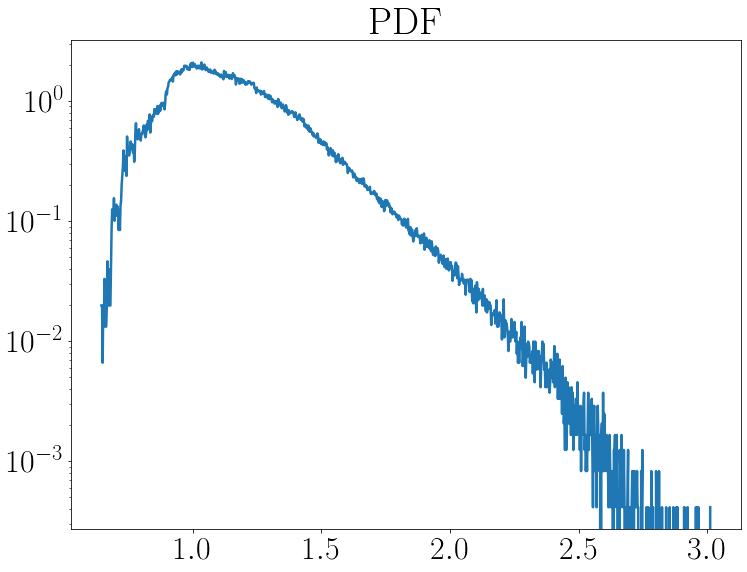

In [16]:
pdf = PDF(imbin, bins=None)  
pdf.run(verbose=False, do_fit=False)

figure(figsize=(12,9))
pdfbinsdl = pdf.bins
pdfdl = pdf.pdf
plot(pdfbinsdl, pdfdl)
yscale('log')
title('PDF')

## Wavelet transform and segmentation
*fan_trans* is the main function used for the Multi-scale non-Gaussian Segmentation (MnGSeg) procedure. The **pywavan** package can be installed using the following command:

`pip install git+https://github.com/jfrob27/pywavan.git`

*fan_trans* decompose the map in a set of quasi-orthogonal complex Morlet wavelets as a function of scales and orientations of spatial fluctuations. For a **q** parameter different of zero, *fan_trans* will segment the wavelet coefficients as a function of scales and orientations in order to separate the non-Gaussianities. The parameter **q** is related to the threshold, which is optimised for every directions and scales when **qdyn** is set to **True**.

The command `fan_trans?` will give you the manual for the function. For this analysis, we will use outputs **wav_k** and **S1a**, which are respectively the vector of scales and averaged wavelet power spectra. **wt** are the complex wavelet coeffcients. We will them to reconstruct the Gaussian (fractal) plus coherent (non-Gaussian) parts of the map. 

In [11]:
#Set a list of q
q=[]
q=[2.9]*nb_scale(imzmbin.shape)

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imzmbin, reso=1, q=q, qdyn=True, skewl=0.4)

100%|██████████| 24/24 [22:38<00:00, 56.62s/it] 


In [12]:
np.save('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_wt.npy',wt)
np.save('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_q.npy',q)

In [24]:
wav_k = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_wav_k.npy')
S1a = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_S1a.npy')
wt = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_wt.npy')
S11a = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_S11a.npy')
q = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_00218_z_q.npy')

INFO: Auto-setting vmin to  6.199e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.855e+00 [aplpy.core]


INFO: Auto-setting vmin to  7.641e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.995e+00 [aplpy.core]


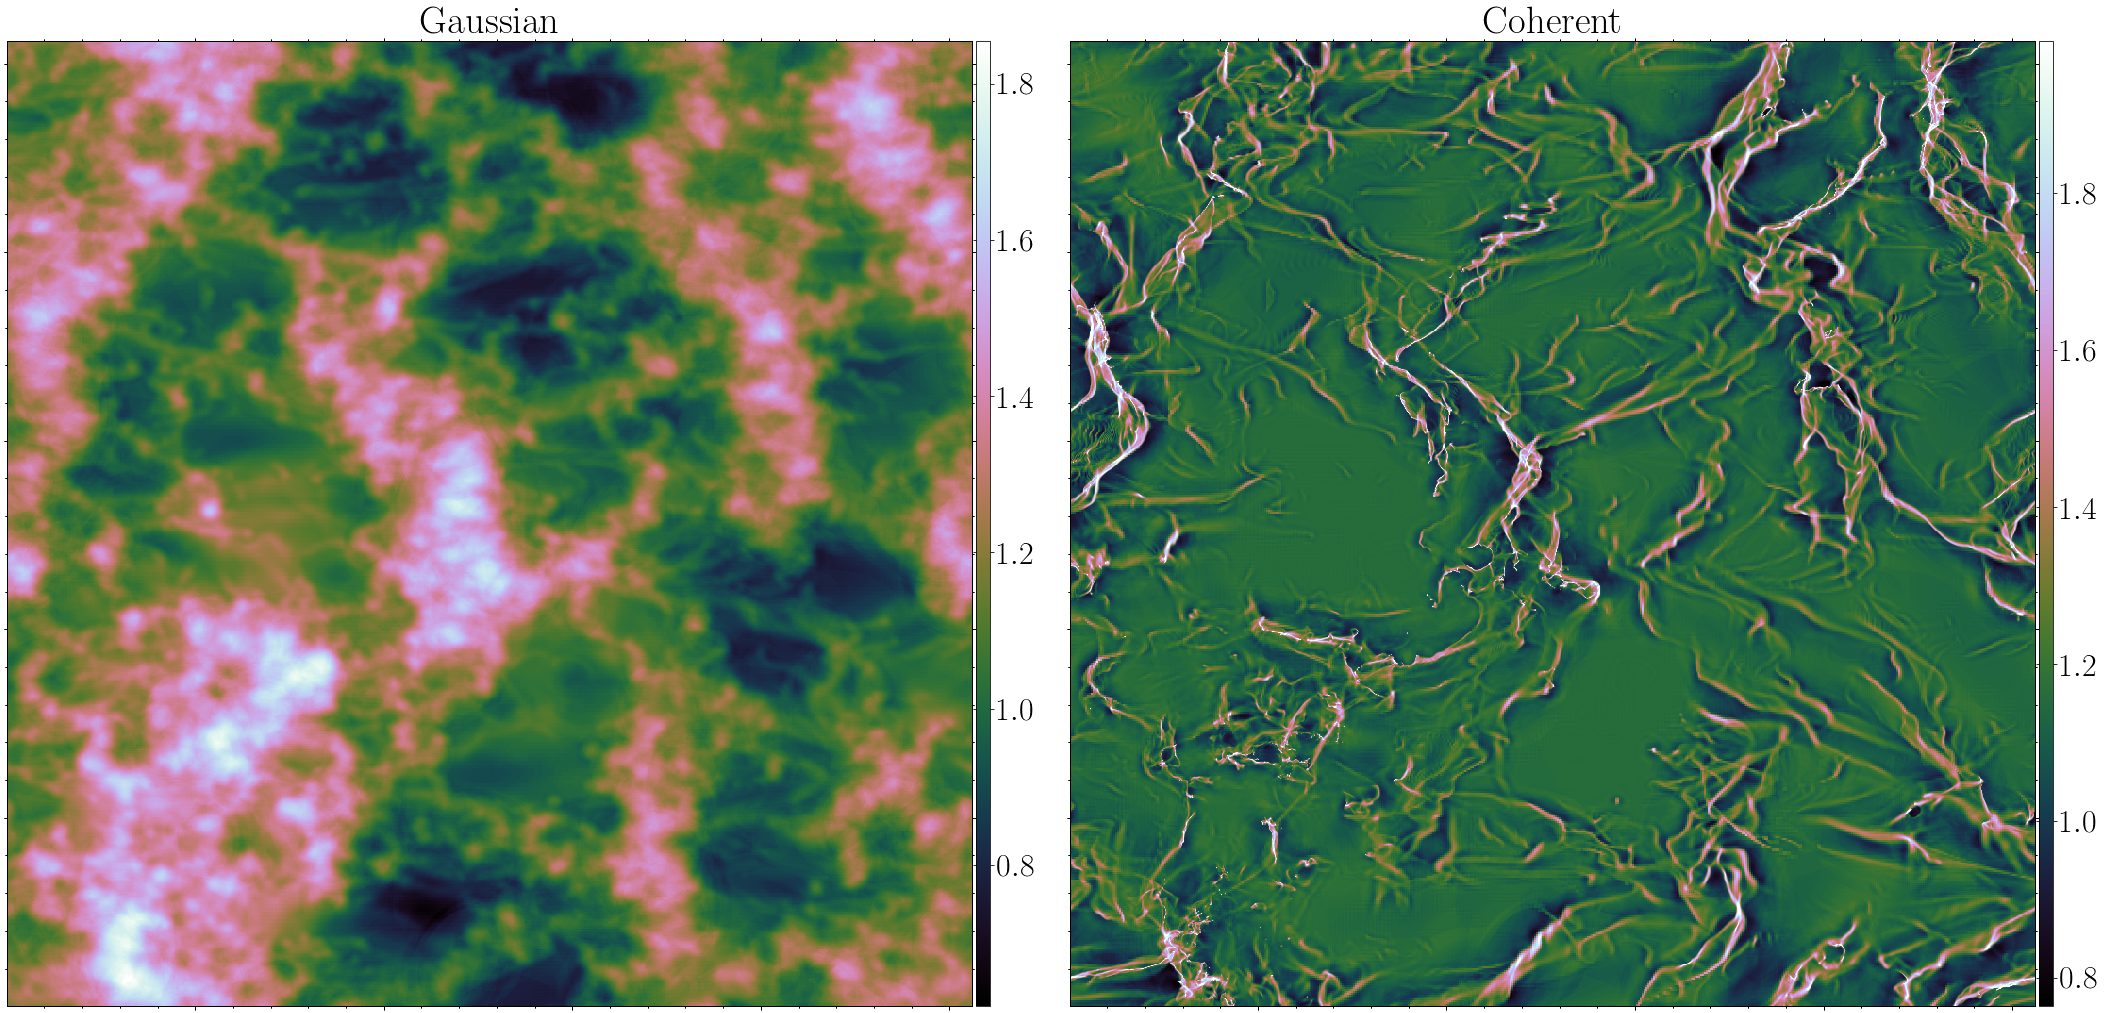

In [13]:
M = nb_scale(imzmbin.shape)

#Map reconstruction of the Gaussian (fractal) and coherent (non-Gaussian) part
coherent = np.sum(wt[M:2*M,:,:],axis=0).real + meanimbin
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0).real + meanimbin

fig_all = plt.figure(1, figsize=(30,15))

fig = aplpy.FITSFigure(fits.PrimaryHDU(Gaussian), figure=fig_all, subplot=(1, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Gaussian')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent), figure=fig_all, subplot=(1, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Coherent')

plt.tight_layout()

In [14]:
#Bin Normalisation
tab_kbinc, wav_kc = tab_kbin/4., wav_k/4.
spec_kbinc, S1ac = spec_kbin*4.**2., S1a*4.**2.

### Wavelet power spectra

The wavelet transforms are designed to reproduce the Fourier power spectrum when the coefficeints are averaged:

$$P^W(l,\vec{x})=\frac{\delta \theta}{N_{\theta}} \sum_{j=0}^{N_{\theta}-1}  |\tilde{f}(l,\vec{x},\theta_j)|^2$$

$$P^W(l)=\frac{1}{N_{\vec{x}}} \sum_{\vec{x}} P^W(l,\vec{x})$$

where $\tilde{f}(l,\vec{x},\theta)$ are the Morlet wavelet coefficients for map $f(\vec{x})$ and $N_{\theta}=\Delta \theta/\delta \theta$ is the number of directions $\theta$ needed to sample the Fourier space over the range $\Delta \theta$ ([Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190511492R/abstract)).

The Fourier power spectrum is not sensitive to non-Gaussianities. However, the wavelet segmentation allows us to calculate their enegy distribution through the wavelet power spectrum of non-Gaussian coefficients only (**Coherent PS**). In the litterature and according to the fractal formalism ([Frisch 1995](http://adsabs.harvard.edu/abs/1995turb.book.....F)), the Gaussian field, which respect a power law scaling, is mono-fractal by nature, and thus fully described by its single power law. The non-Gaussian part has multi-fractal properties ([Robitaille et al. 2020](https://arxiv.org/abs/2007.08206)) and, consequently, cannot be fully described by its power spectrum. Nevertheless, the coherent power spectrum can give us an estimation of the non-Gaussian energy distribution as a function of scales.

Gaussian Power law
-2.454898057792219 

Coherent Power law
0.9777932749877762
-1.756888153470431
-3.156941931540061


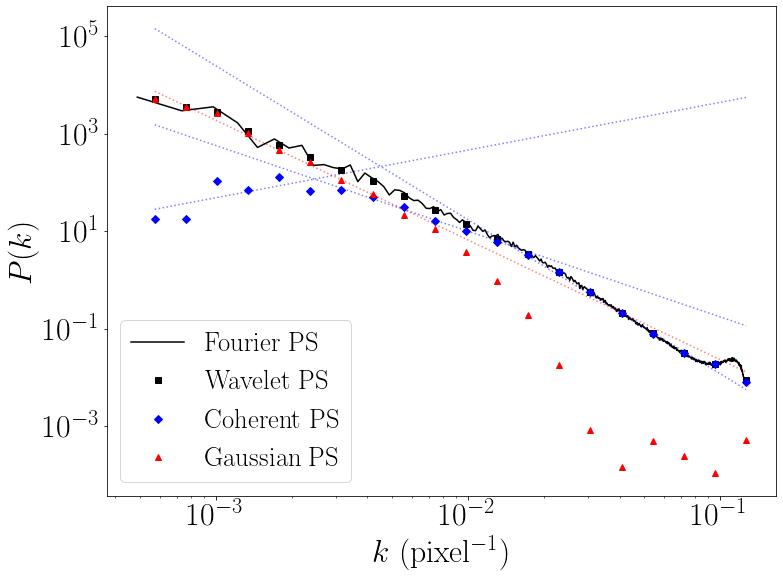

In [15]:
# Gaussian Power law fit
coefw,cov = np.polyfit(np.log(wav_kc[3:12]),np.log(S1ac[2,3:12]),deg=1,cov=True)
yfitw = np.exp(coefw[1])*wav_kc**coefw[0]

print('Gaussian Power law')
print(coefw[0],'\n')

# Coherent Power law fit 1/3
coefcw,cov = np.polyfit(np.log(wav_kc[4:9]),np.log(S1ac[1,4:9]),deg=1,cov=True)
yfitcw = np.exp(coefcw[1])*wav_kc**coefcw[0]

print('Coherent Power law')
print(coefcw[0])

# Coherent Power law fit 2/3
coefcw2,cov = np.polyfit(np.log(wav_kc[9:14]),np.log(S1ac[1,9:14]),deg=1,cov=True)
yfitcw2 = np.exp(coefcw2[1])*wav_kc**coefcw2[0]

print(coefcw2[0])

# Coherent Power law fit 3/3
coefcw3,cov = np.polyfit(np.log(wav_kc[14:21]),np.log(S1ac[1,14:21]),deg=1,cov=True)
yfitcw3 = np.exp(coefcw3[1])*wav_kc**coefcw3[0]

print(coefcw3[0])

plt.figure(figsize=(12,9))
plt.plot(tab_kbinc[1:], spec_kbinc[1:], color='black',label='Fourier PS', linewidth=1.5)
plt.plot(wav_kc[3:-1], S1ac[0,3:-1],'s',color='black', label='Wavelet PS')
plt.plot(wav_kc[3:-1], S1ac[1,3:-1],'D',color='blue', label='Coherent PS')
plt.plot(wav_kc[3:-1], S1ac[2,3:-1],'^',color='red', label='Gaussian PS')
#plt.plot(tab_kbin/4., yfit*4.**2.,':', color='black',label='Fits', linewidth=1.5, alpha=0.5)
plt.plot(wav_kc[3:-1], yfitw[3:-1],':', color='red', linewidth=1.5, alpha=0.5)
plt.plot(wav_kc[3:-1], yfitcw[3:-1],':', color='blue', linewidth=1.5, alpha=0.5)
plt.plot(wav_kc[3:-1], yfitcw2[3:-1],':', color='blue', linewidth=1.5, alpha=0.5)
plt.plot(wav_kc[3:-1], yfitcw3[3:-1],':', color='blue', linewidth=1.5, alpha=0.5)
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (pixel$^{-1}$)")
plt.ylabel(r"$P(k)$")
plt.legend(fontsize="small")

## Analysis...

| PS | Delayed Gravity | Not Delayed | No forcing |
| :- | -: | -: | -: |
| Fourier | $-2.21$ | $-2.40$ | $-2.15$ |
| Gaussian | $-2.78$ | $-2.99$ | $-2.45$ |
| Coherent 1 | $-0.04$ | $-1.26$ | $0.98$ |
| Coherent 2 | $-1.42$ | $-2.28$ | $-1.76$ |
| Coherent 3 | $-3.05$ | $-3.14$ | $-3.16$ |
Power laws of both simulations

Coherent power laws for the simulation without forcing are closer to the delayed gravity simulation. The main difference is the "lack" of coherence at large scales. The positive power law and the bad fit probably means that the algorithm had a hard time to find non-Gaussianities.

See below the integration (reconstruction) over the non-Gaussianities at large scale only with forcing and without forcing.

In [18]:
#Load gravity + forcing simulation
wtf = np.load('/Users/robitaij/postdoc/CEA_simu/analysis/simu_048_z_wt.npy')

In [20]:
from pywavan import imsmooth

INFO: Auto-setting vmin to -6.513e-02 [aplpy.core]
INFO: Auto-setting vmax to  7.065e-02 [aplpy.core]


INFO: Auto-setting vmin to -4.972e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.336e-02 [aplpy.core]


INFO: Auto-setting vmin to -4.107e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.246e-01 [aplpy.core]


INFO: Auto-setting vmin to  7.681e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.933e+00 [aplpy.core]


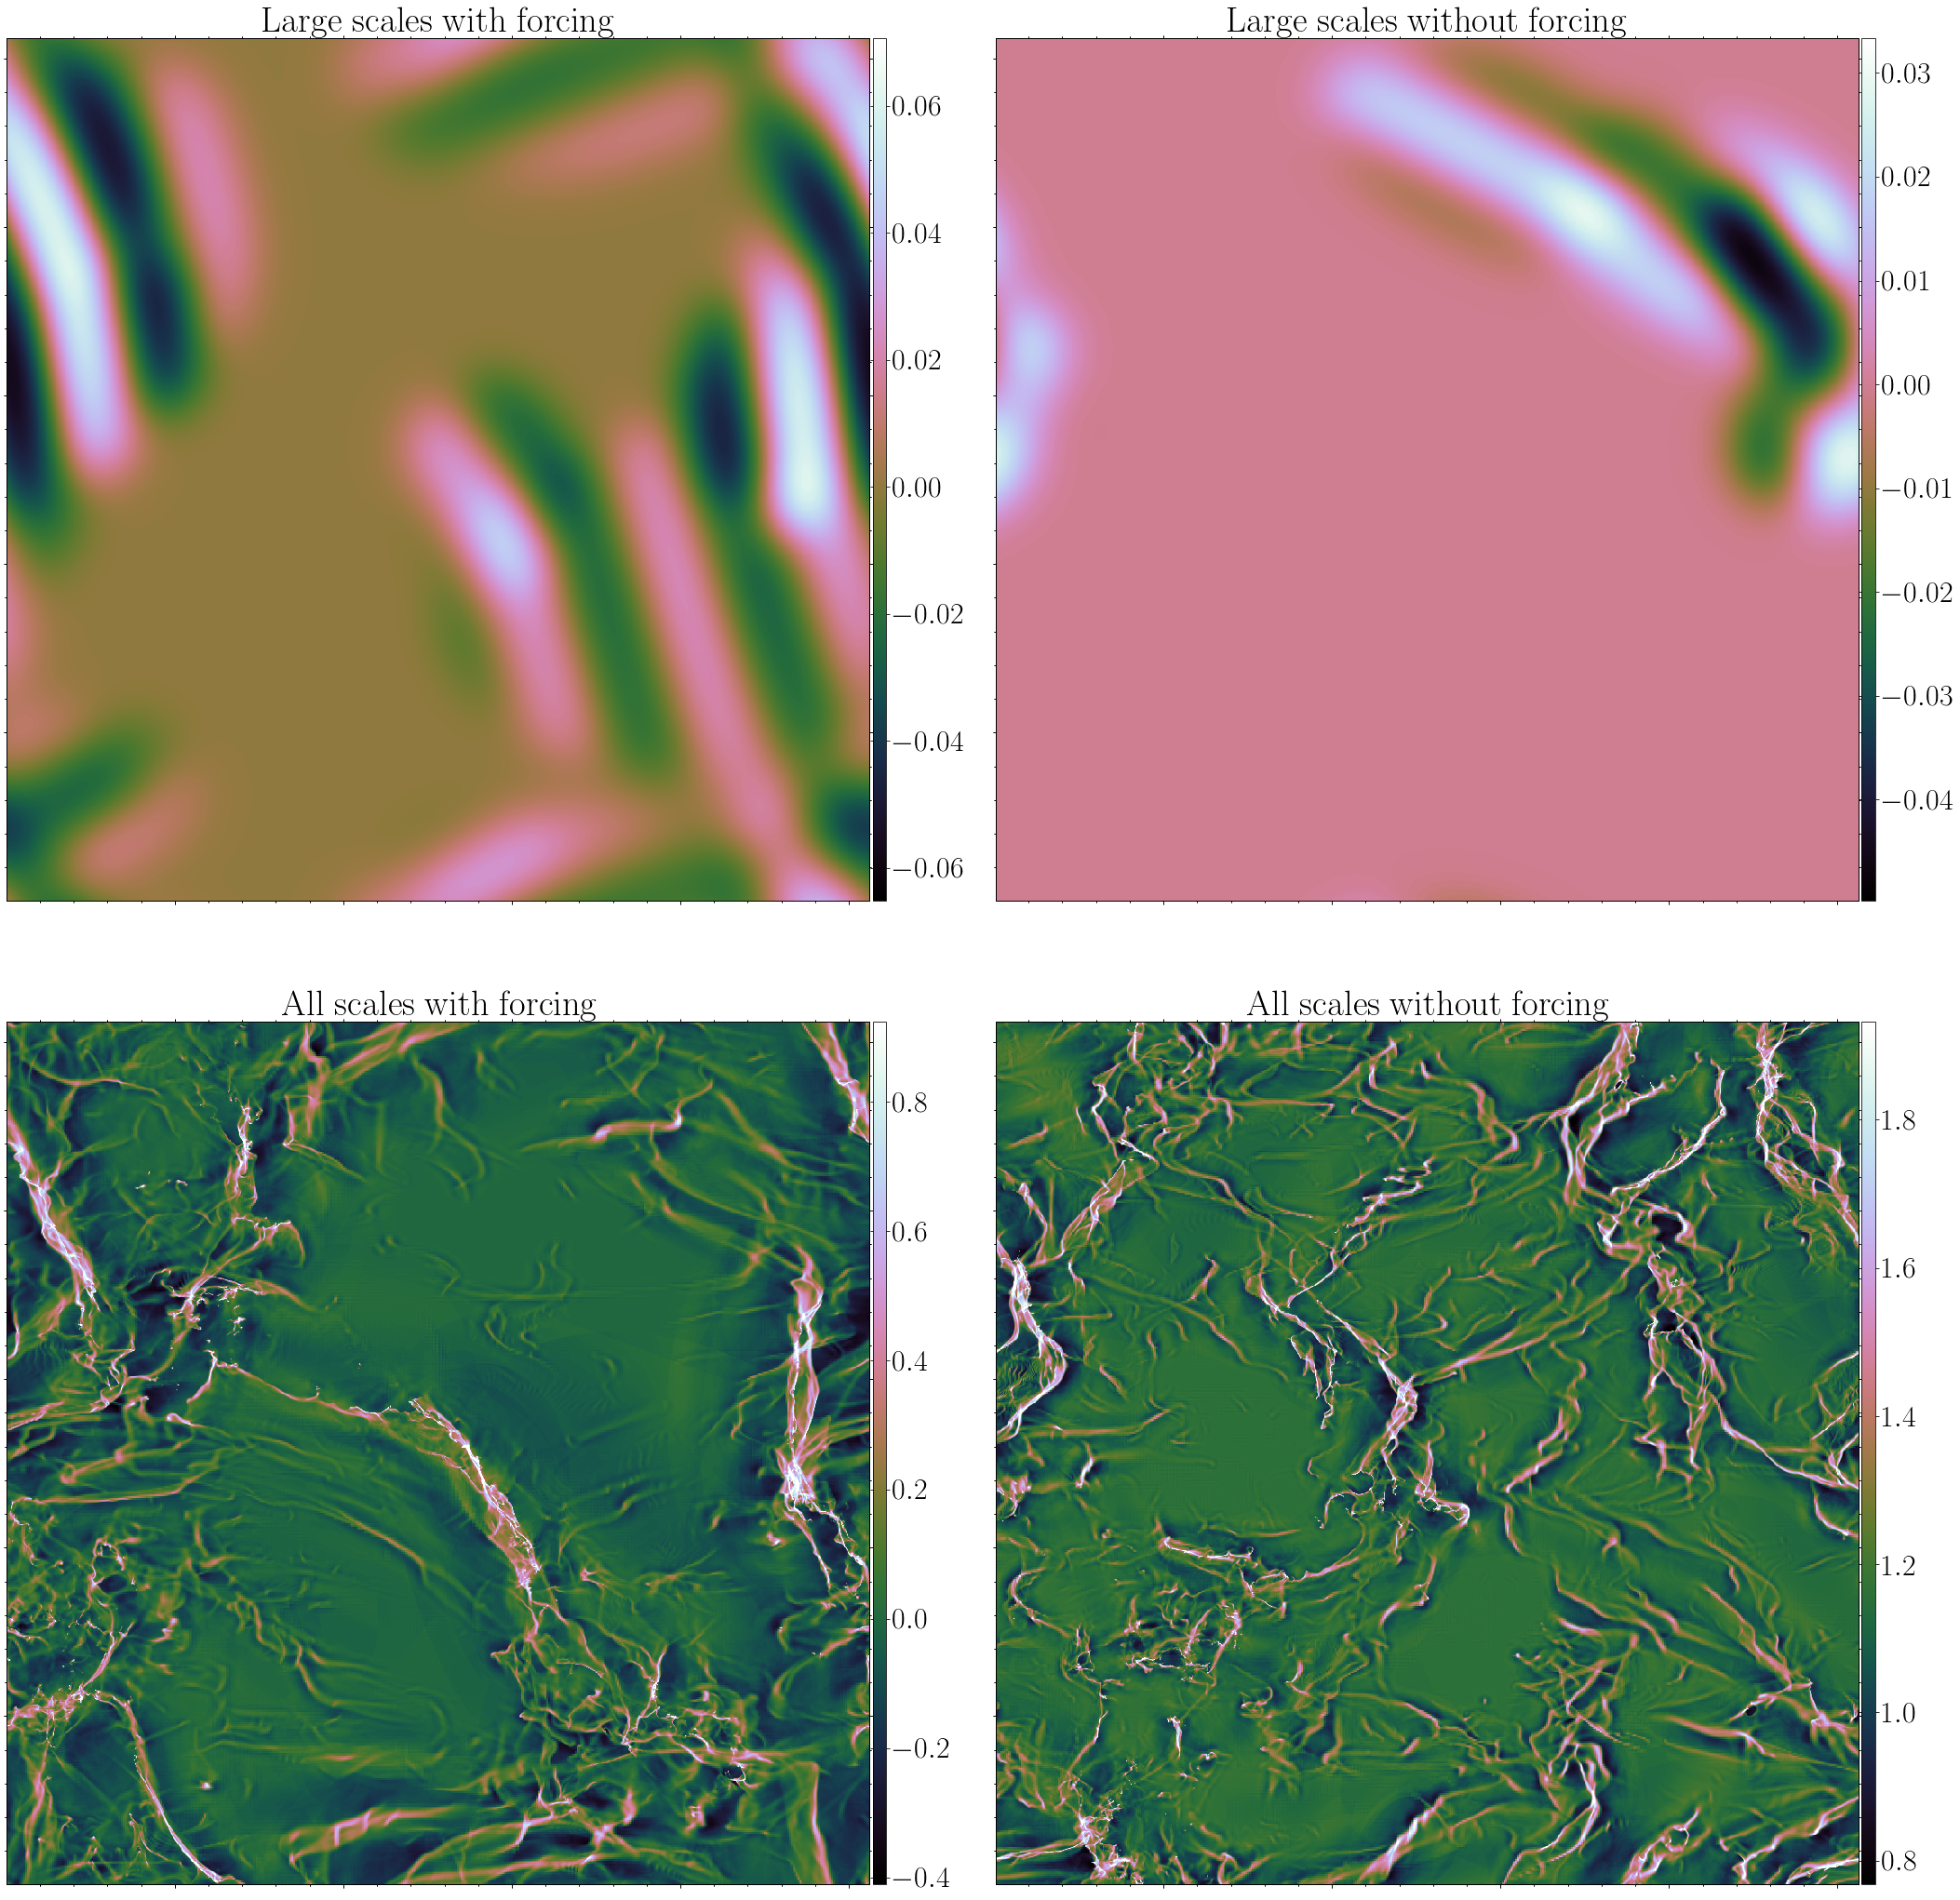

In [28]:
M = nb_scale(imzmbin.shape)

#Integration (with smoothing) at large scales only
coherent_ls = np.zeros(imzm.shape)
fcoherent_ls = np.zeros(imzm.shape)
for i in range(7):
    coherent_ls =+ imsmooth(wt[M+i,:,:].real, (2.*np.sqrt(2.*np.log(2.)))/(wav_k[i]*2.*np.pi))
    fcoherent_ls =+ imsmooth(wtf[M+i,:,:], (2.*np.sqrt(2.*np.log(2.)))/(wav_k[i]*2.*np.pi))

fig_all = plt.figure(1, figsize=(30,30))

fig = aplpy.FITSFigure(fits.PrimaryHDU(fcoherent_ls), figure=fig_all, subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Large scales with forcing')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent_ls), figure=fig_all, subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('Large scales without forcing')

fig = aplpy.FITSFigure(fits.PrimaryHDU(np.sum(wtf[M:2*M,:,:],axis=0).real), figure=fig_all, subplot=(2, 2, 3))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('All scales with forcing')

fig = aplpy.FITSFigure(fits.PrimaryHDU(coherent), figure=fig_all, subplot=(2, 2, 4))
fig.show_colorscale(cmap='cubehelix')
fig.add_colorbar()
fig.axis_labels.hide()
fig.tick_labels.hide()
fig.set_title('All scales without forcing')

plt.tight_layout()

With forcing, we clearly see large-scale fluctuations following the main filaments. Without forcing, large-scale fluctuations are twice lower and not all coherent with the small-scale non-Gaussianities.